In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping
from random import choice

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train / 255
x_test = x_test / 255



x_train.shape, y_train.shape, x_test.shape, y_test.shape



((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [16]:
# Список оптимизаторов и функций активации
optimizers_list = [
    tf.keras.optimizers.Adam,
    tf.keras.optimizers.SGD,
    tf.keras.optimizers.RMSprop
]

activation_list = [
    'relu',
    'tanh',
    'sigmoid',
    'elu'
]

# Список количества нейронов в слоях
units_list = [[64, 16],[64,32]]

learning_rate_list = [0.01, 0.1, 0.001]

dropout_rate_list = [0.0, 0.1]

batch_size_list = [64, 128]

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience = 3,
    restore_best_weights= True
)

collect = {}

# Function to build the model dynamically
def build_model(units, activation, optimizer, learning_rate, dropout_rate):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))

    for i, num_units in enumerate(units):
        model.add(tf.keras.layers.Dense(num_units, activation=activation))
        if i < len(units) - 1 and dropout_rate > 0:  # Add dropout after hidden layers, not after the last one
            model.add(tf.keras.layers.Dropout(dropout_rate))

    model.add(tf.keras.layers.Dense(10, activation="softmax"))

    optimizer_instance = optimizer(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer_instance, metrics=['sparse_categorical_accuracy'])
    return model

# Hyperparameter search loop
for opt in optimizers_list:
    for rate in learning_rate_list:
        for act in activation_list:
            for neyron_layers in units_list:
                for batch_size in batch_size_list:
                    for drop_rate in dropout_rate_list:
                        # Build the model with the current configuration
                        model = build_model(neyron_layers, act, opt, rate, drop_rate)

                        # Training and saving results (rest of your code remains the same)
                        history = model.fit(x_train, y_train, epochs=20, batch_size=batch_size,
                                            validation_data=(x_test, y_test), callbacks=[early_stopping], verbose=0)

                        key = f"{opt.__name__}_{act}_{'_'.join(map(str, neyron_layers))}_batch{batch_size}_lr{rate}_early_stop"
                        collect[key] = {
                            "val_accuracy": history.history['val_sparse_categorical_accuracy'],
                            "train_accuracy": history.history['sparse_categorical_accuracy'],
                            "val_loss": history.history['val_loss'],
                            "train_loss": history.history['loss']
                        }



                                     Configuration  Final Validation Accuracy
130  RMSprop_relu_64_32_batch64_lr0.001_early_stop                     0.8621
36      Adam_tanh_64_16_batch64_lr0.001_early_stop                     0.8617
15       Adam_elu_64_32_batch128_lr0.01_early_stop                     0.8616
32      Adam_relu_64_16_batch64_lr0.001_early_stop                     0.8611
34      Adam_relu_64_32_batch64_lr0.001_early_stop                     0.8607
46       Adam_elu_64_32_batch64_lr0.001_early_stop                     0.8606
38      Adam_tanh_64_32_batch64_lr0.001_early_stop                     0.8601
44       Adam_elu_64_16_batch64_lr0.001_early_stop                     0.8597
35     Adam_relu_64_32_batch128_lr0.001_early_stop                     0.8564
140   RMSprop_elu_64_16_batch64_lr0.001_early_stop                     0.8561


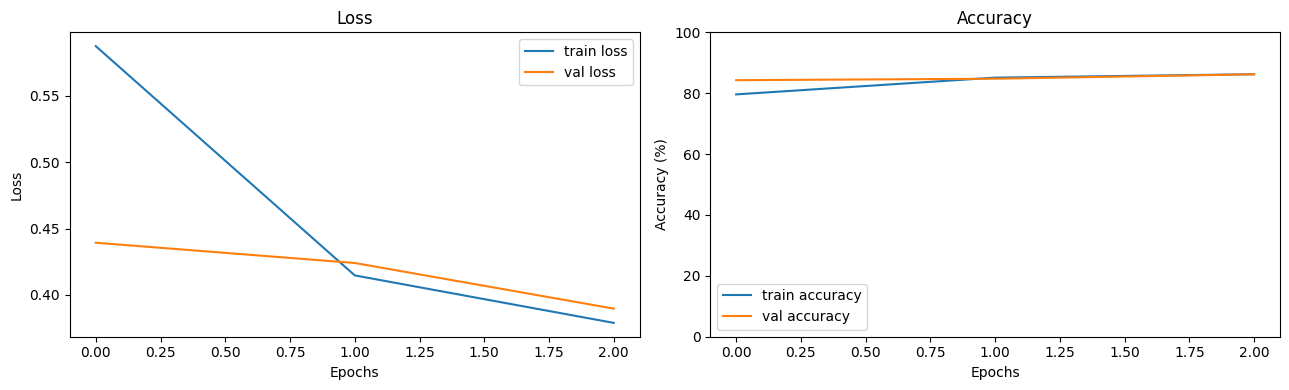

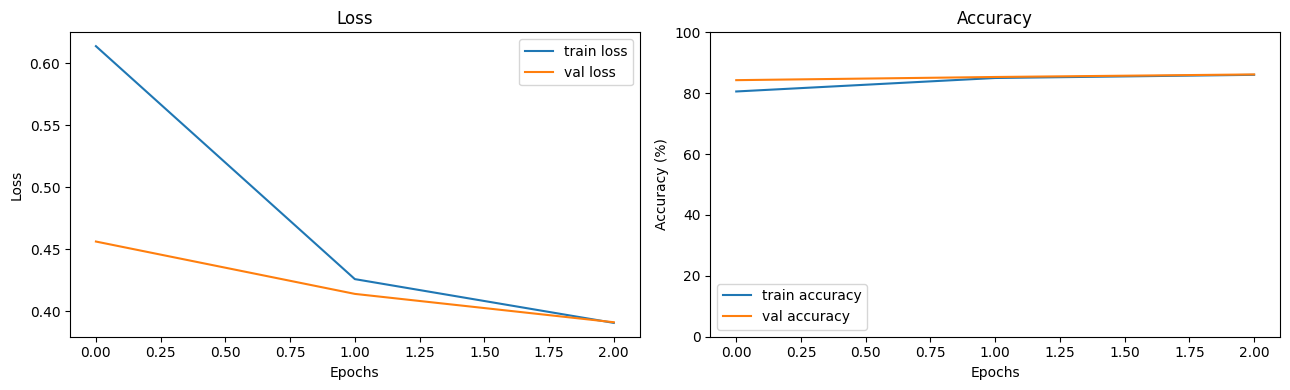

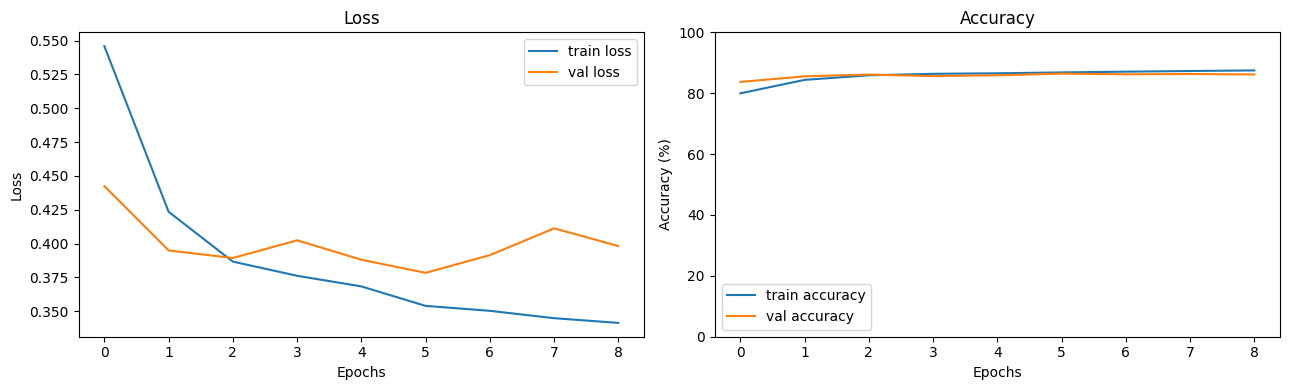

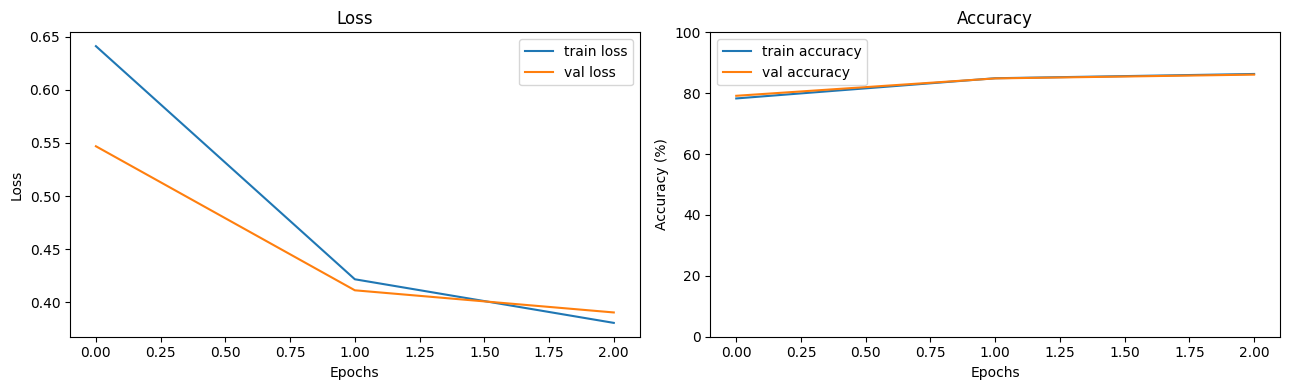

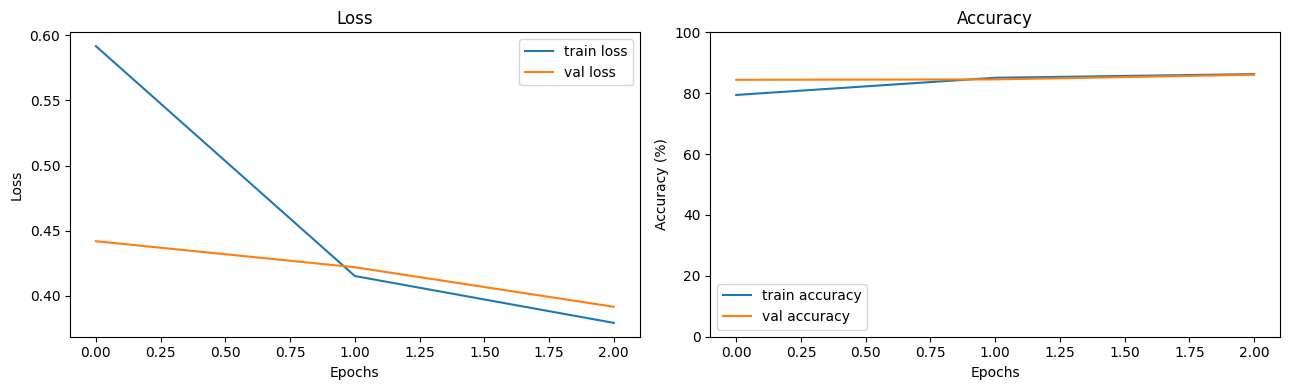

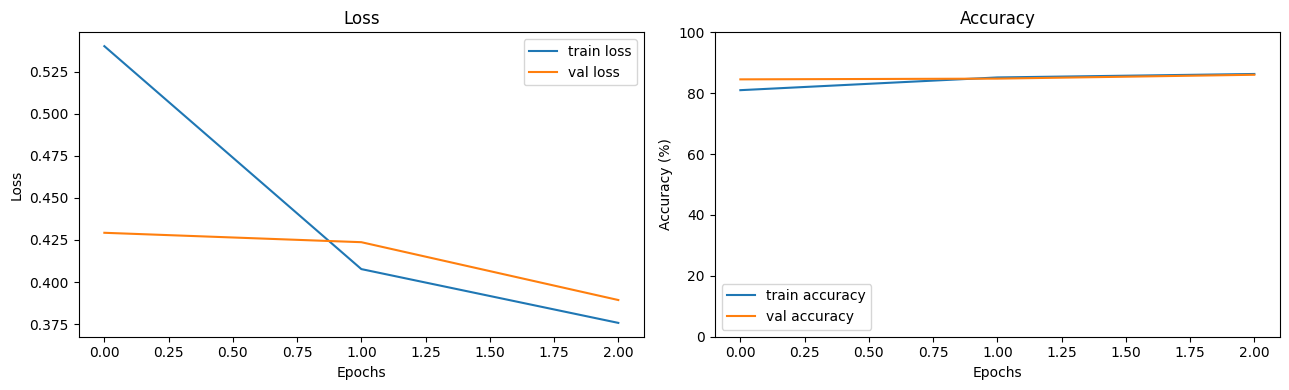

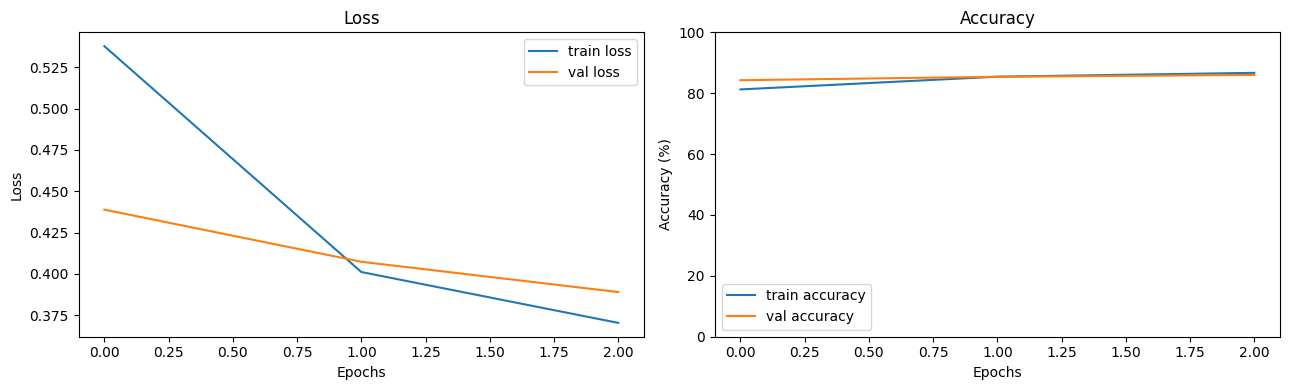

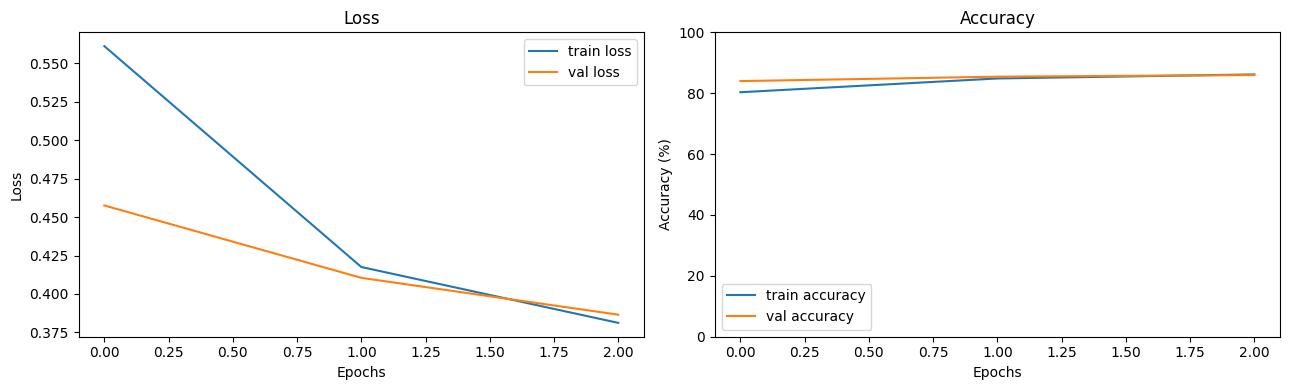

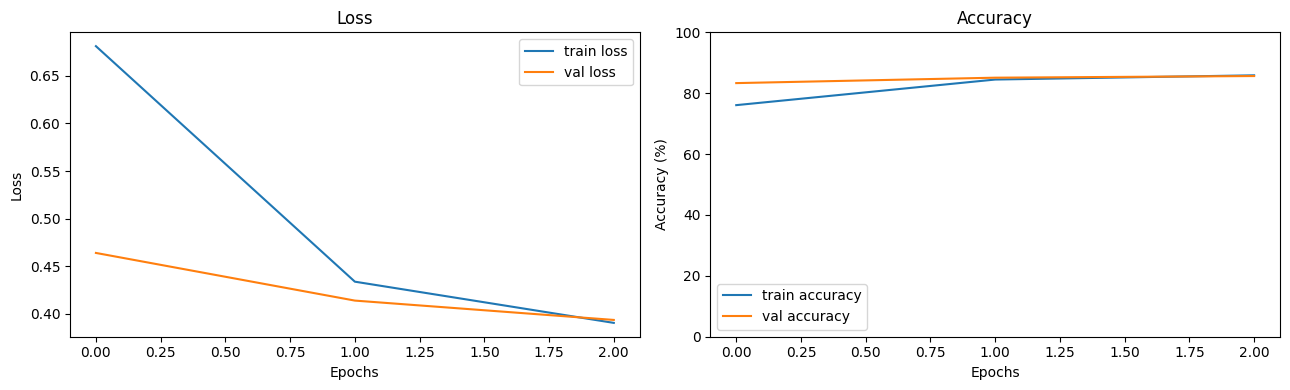

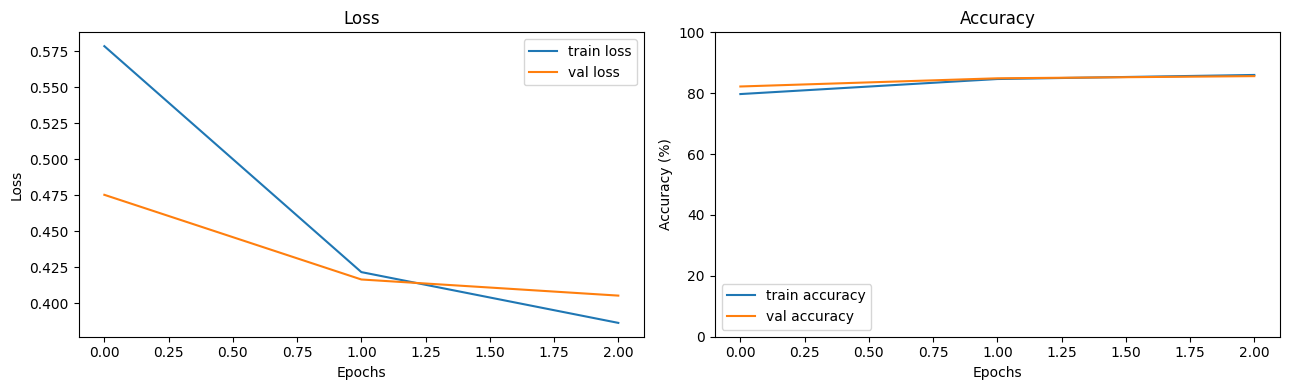

In [17]:
results_df = pd.DataFrame({
    "Configuration": collect.keys(),
    "Final Validation Accuracy":  [val_accuracy[-1] if len(val_accuracy) > 0 else None for val_accuracy in (metrix["val_accuracy"] for metrix in collect.values())]
    })

# Drop any rows where the "Final Validation Accuracy" is None
results_df = results_df.dropna(subset=["Final Validation Accuracy"])

results_df = results_df.sort_values(by="Final Validation Accuracy", ascending=False)
print(results_df.head(10))

list_top10models_for_plot = results_df.head(10)['Configuration']



def plot_history(lst):

    plt.figure(figsize=(13, 4))

    plt.subplot(1, 2, 1)
    plt.plot(range(len(lst[0])), lst[0], label='train loss')
    plt.plot(range(len(lst[1])), lst[1], label='val loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(len(lst[2])), [round(100*e, 2) for e in lst[2]], label='train accuracy')
    plt.plot(range(len(lst[3])), [round(100*e, 2) for e in lst[3]], label='val accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.ylim(0, 100)
    plt.legend()

    plt.tight_layout()
    plt.show()

for model_key in list_top10models_for_plot:
    lst_for_plot = list()

    # Collect metrics for plotting
    train_loss_for_plot = collect[model_key]["train_loss"]
    lst_for_plot.append(train_loss_for_plot)

    valid_loss_for_plot = collect[model_key]["val_loss"]
    lst_for_plot.append(valid_loss_for_plot)

    train_accuracy_for_plot = collect[model_key]["train_accuracy"]
    lst_for_plot.append(train_accuracy_for_plot)

    valid_accuracy_for_plot = collect[model_key]["val_accuracy"]
    lst_for_plot.append(valid_accuracy_for_plot)

    # Plot the history
    plot_history(lst_for_plot)

